In [1]:
%matplotlib nbagg
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# from scipy.optimize import curve_fit

path = 'X:\\RIXS\\InHouse_e18695\\CrCl3_Jan_2022\\RIXS\\'
base = 'Cr'
energyDispersion = 0.00535 #eV/subpixel

In [34]:
def elasticShift(pixelData):

    global energyDispersion

    peaks, _ = signal.find_peaks(pixelData,height=10,width=3)
    xdataPixel = np.arange(len(pixelData))
    
    xdataPixel = xdataPixel[(peaks[-1]-2000):(peaks[-1]+200)]
    energyData = pixelData[(peaks[-1]-2000):(peaks[-1]+200)]
    
    xDataEnergy = (xdataPixel - peaks[-1]) * energyDispersion * -1

    return [xDataEnergy,energyData]

def xCorr(refData, uncorrData):

    corr = signal.correlate(refData, uncorrData)
    lag = np.argmax(corr)
    corrData = np.roll(uncorrData, lag)

    return corrData

def getData(scannumber):
    global path
    global base
    
    if scannumber < 10:
        filename = base+"_"+"000"+str(scannumber)
    elif scannumber < 100:
        filename = base+"_"+"00"+str(scannumber)
    elif scannumber < 1000:    
        filename = base+"_"+"0"+str(scannumber)
    else:    
        filename = base+"_"+str(scannumber)

    f1 = h5py.File(path+filename+"_d1.h5", 'r')
    f2 = h5py.File(path+filename+"_d2.h5", 'r')
    f3 = h5py.File(path+filename+"_d3.h5", 'r')

    ccd1 = f1['entry']['analysis']['spectrum'][()]
    ccd2 = f2['entry']['analysis']['spectrum'][()]
    ccd3 = f3['entry']['analysis']['spectrum'][()]
    
    ccd1 = xCorr(ccd2,ccd1)
    ccd3 = xCorr(ccd2,ccd3)
    xdata,tempData = elasticShift(ccd1+ccd2+ccd3)
    
    return [xdata,tempData]

def getScans(scans):
    for i,scannumber in enumerate(scans):
        if i == 0:
            [xdata,ydata] = getData(scannumber)
            refdata = ydata
            sumdata = ydata
        else:
            [_,ydata] = getData(scannumber)
            ydata = xCorr(refdata,ydata)
            sumdata = sumdata+ydata
    return [xdata,sumdata]


<IPython.core.display.Javascript object>


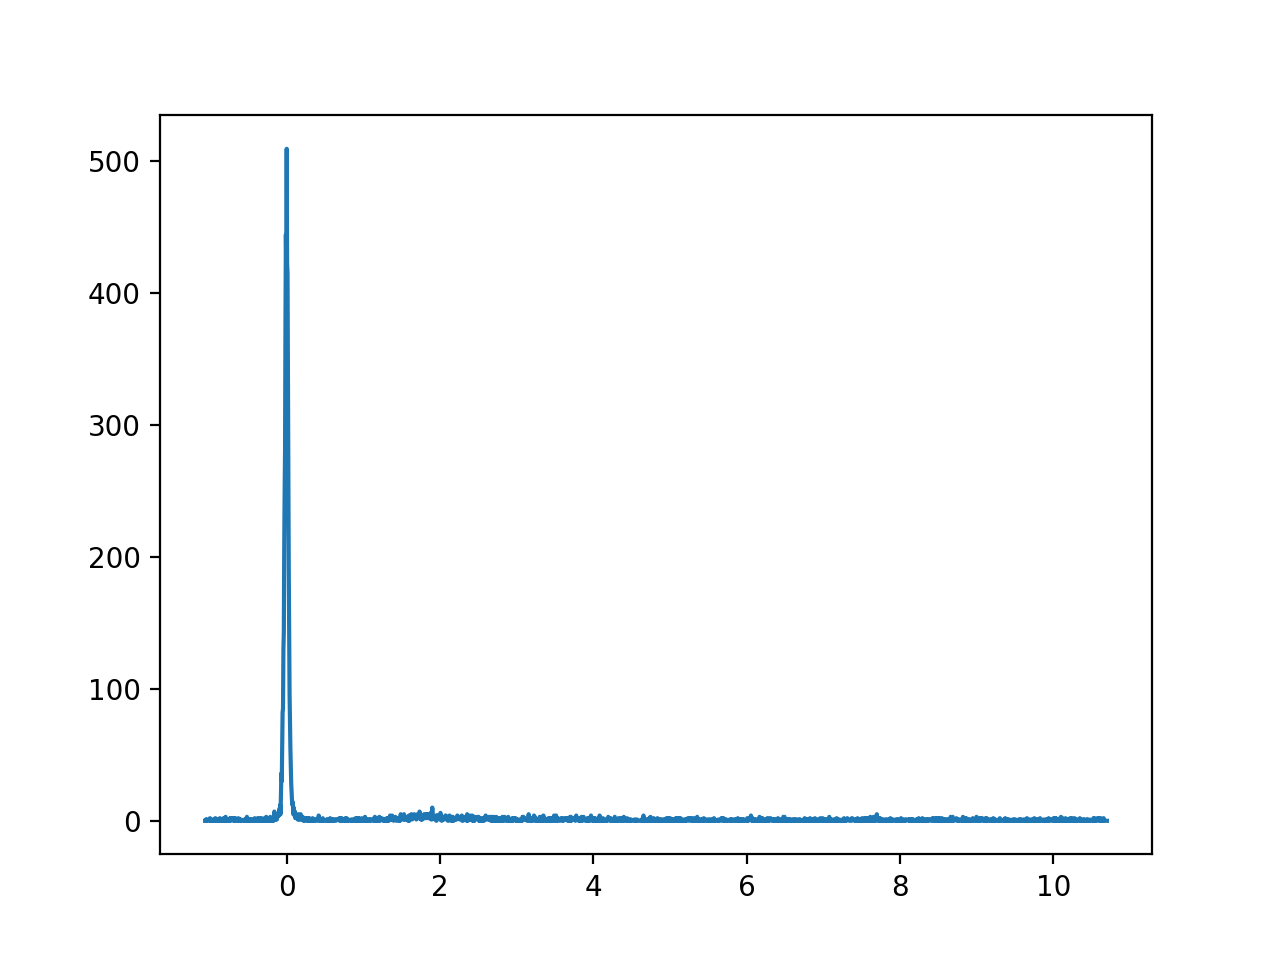

In [35]:
fig = plt.figure()
[X,Y]=getData(105)
plt.plot(X,Y);

<IPython.core.display.Javascript object>


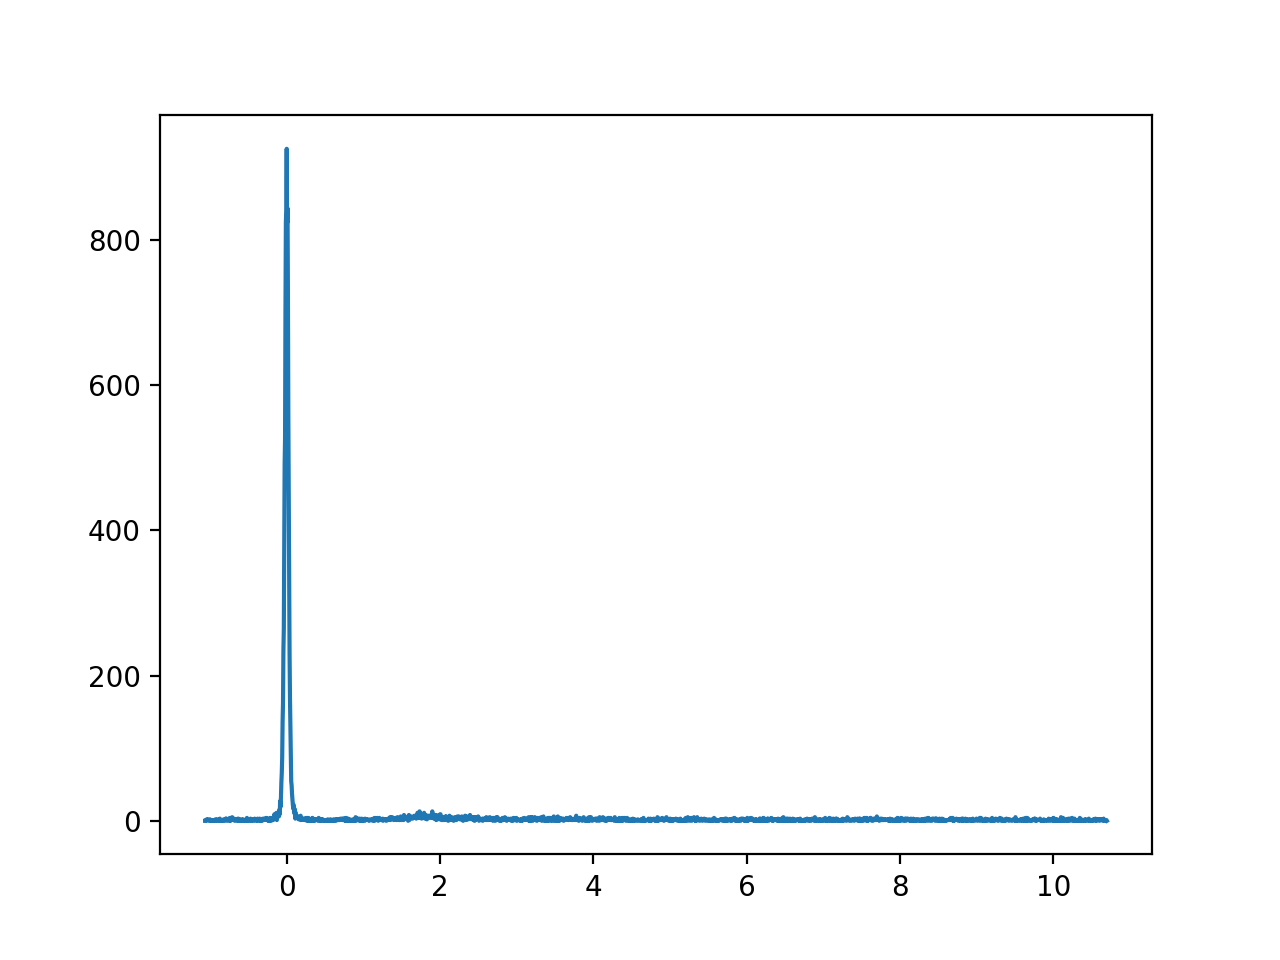

In [36]:
fig = plt.figure()
[X,Y]=getScans([105,106])
plt.plot(X,Y);

<IPython.core.display.Javascript object>


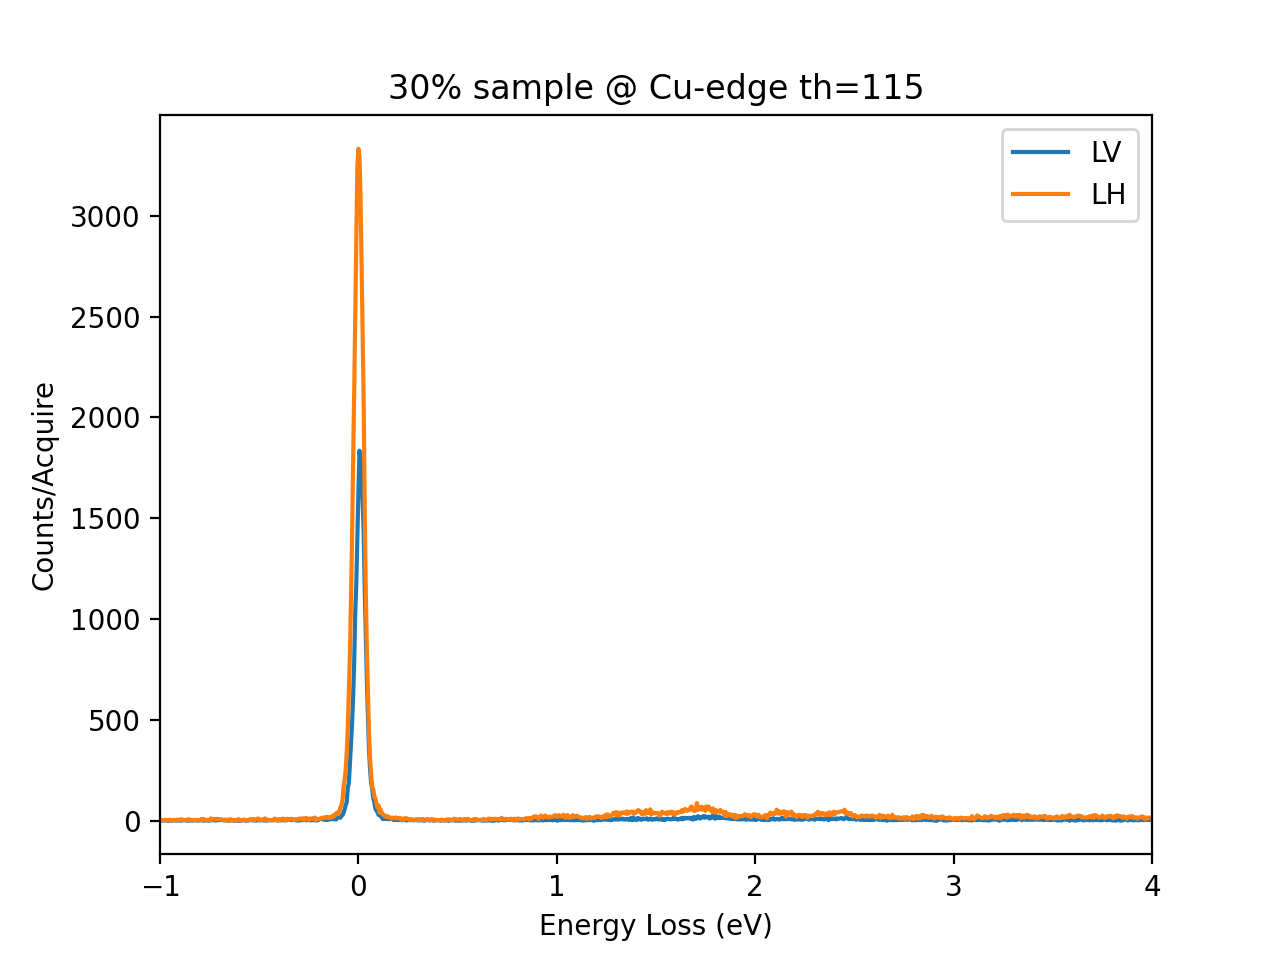

In [38]:
fig = plt.figure() 

#####################################

scans = range(289,293+1)
[X,Y]=getScans(scans)
plt.plot(X,Y,  label='LV')

######################################

scans = range(442,446+1)
[X,Y]=getScans(scans)
plt.plot(X,Y, label='LH')

######################################

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Counts/Acquire')
plt.xlim([-1,4])
plt.title('30% sample @ Cu-edge th=115')
plt.legend();

<IPython.core.display.Javascript object>


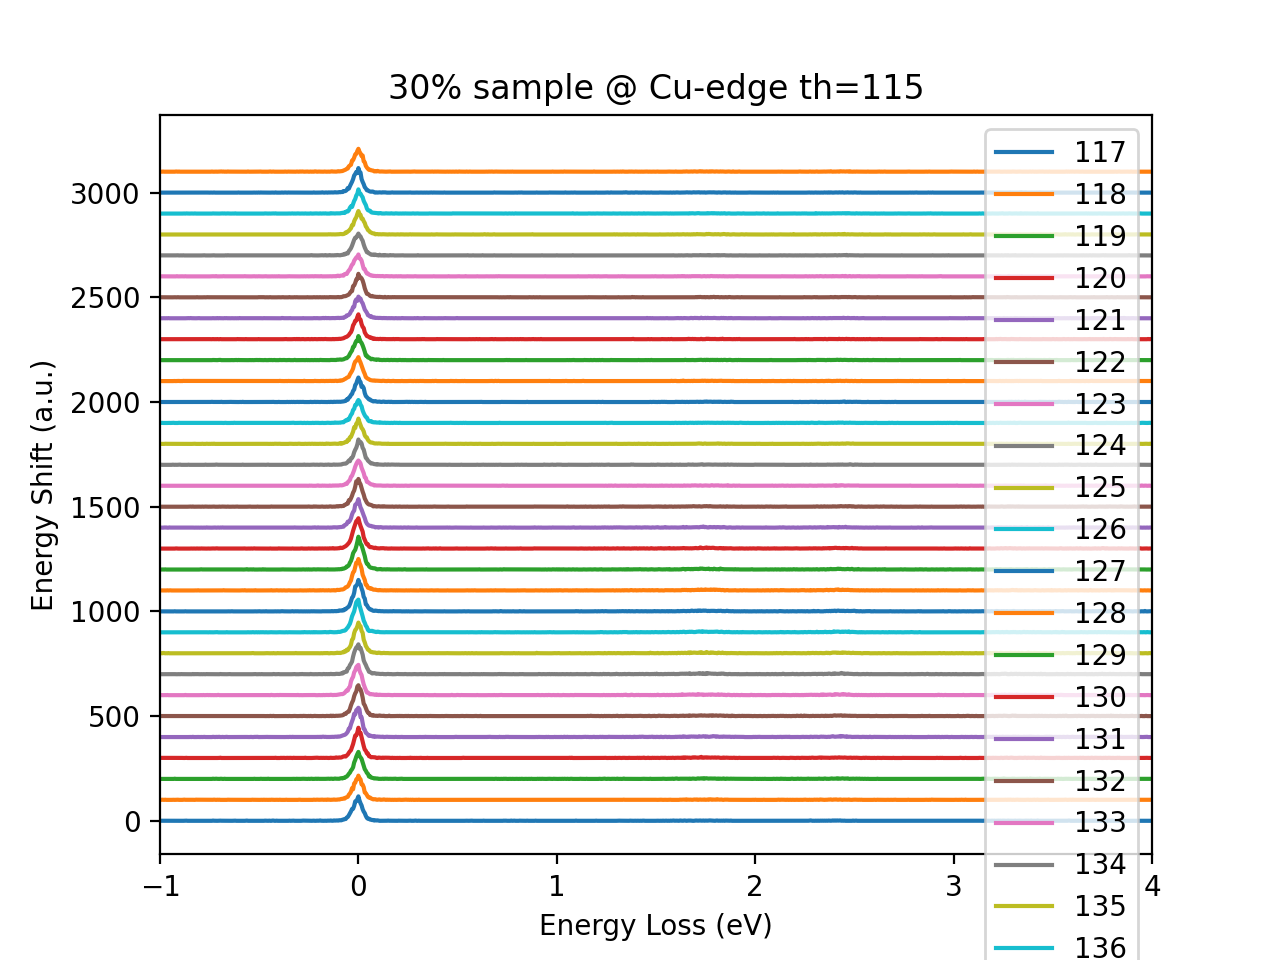

In [24]:
fig = plt.figure()

scans = np.arange(117,148+1)

sumData = np.zeros(2200)

for i,s in enumerate(scans):
    [xData,oneData] = getData(s)
    plt.plot(xData,oneData+100*i,label=str(s))

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Energy Shift (a.u.)')
plt.xlim([-1,4])
plt.title('30% sample @ Cu-edge th=115')
plt.legend(loc='upper right');

<IPython.core.display.Javascript object>


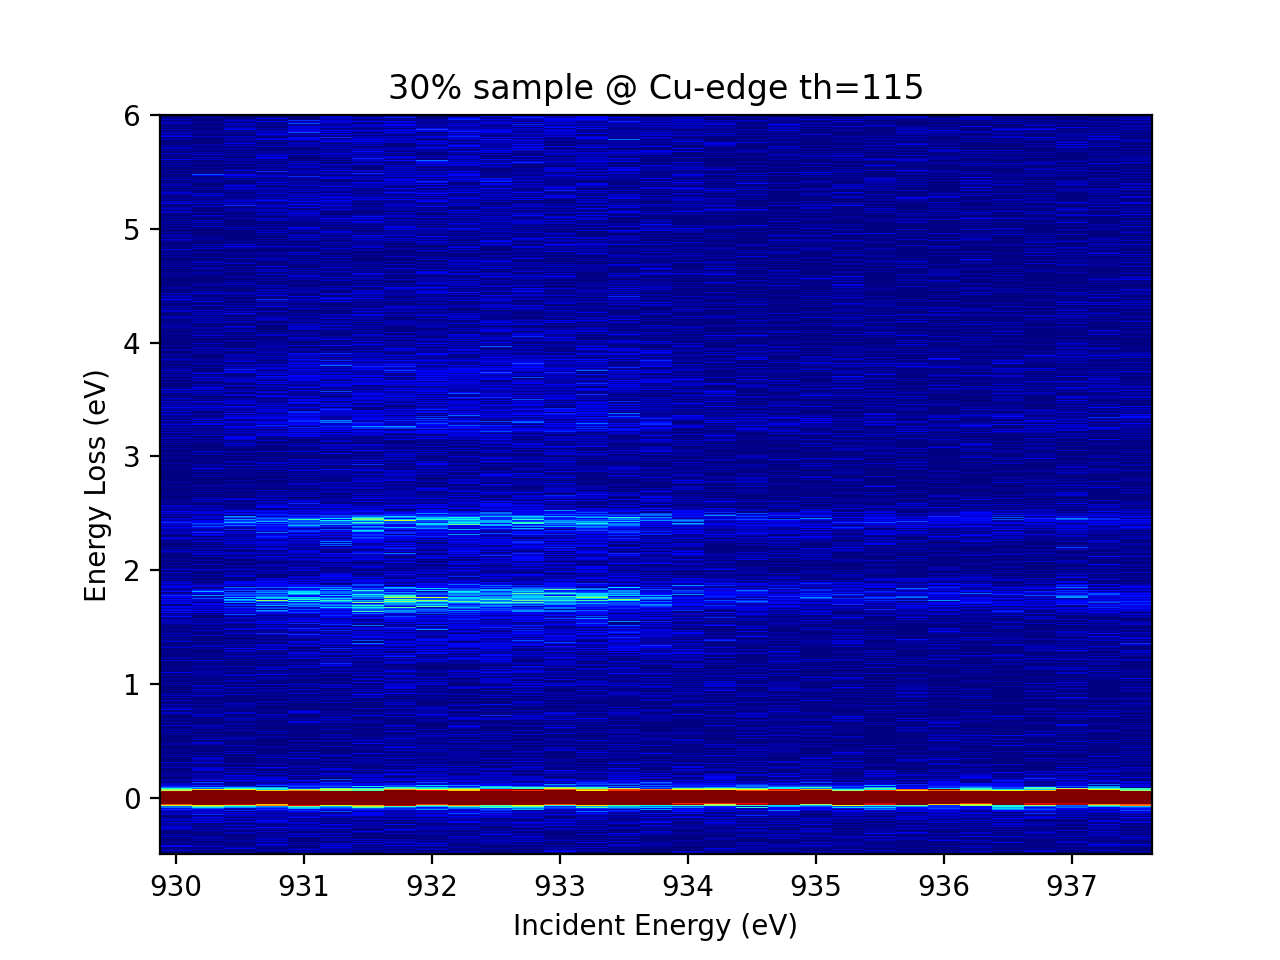

In [25]:
fig = plt.figure()

scans = np.arange(117,147+1)
Ei = np.arange(930,937.5+0.1,0.25)
eiNum = len(scans)

matrixData = np.zeros((2200, eiNum))

for i,s in enumerate(scans):
    [Eloss,oneData] = getData(s)
    matrixData[:,i] = oneData.T

X,Y = np.meshgrid(Ei,Eloss)

plt.pcolormesh(X,Y,matrixData,shading='auto',cmap='jet',vmax=10)
plt.ylim([-0.5,6])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('30% sample @ Cu-edge th=115');